In [14]:
# The %... is an iPython thing, and is not part of the Python language.
# In this case we're just telling the plotting library to draw things on
# the notebook, instead of on a separate window.
%matplotlib inline

# See all the "as ..." contructs? They're just aliasing the package names.
# That way we can call methods like plt.plot() instead of matplotlib.pyplot.plot().
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import time
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 40)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook")

from bs4 import BeautifulSoup
from collections import OrderedDict # provides the ordered dictionary
import re # for regular expressions used below
import urllib # to read from URLs
import json
import networkx as nx # network analysis
from networkx.readwrite import json_graph
import itertools
import os.path
from datetime import datetime # for time measurement
import sys
import os
import pickle
import gzip
import math
import codecs
import csv

import scipy.cluster.hierarchy as scipycluster
from sklearn.feature_extraction.text import TfidfVectorizer

from skimage import io, exposure
from scipy.spatial import distance
# import the k-means algorithm
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import pairwise_distances_argmin,pairwise_distances_argmin_min, pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances

def printLog(text):
    now=str(datetime.now())
    print("["+now+"]\t"+text)
    # forces to output the result of the print command immediately, see: http://stackoverflow.com/questions/230751/how-to-flush-output-of-python-print
    sys.stdout.flush()
    
def pickleCompress(fileName,pickledObject):
    printLog("Pickling to '%s'" %fileName)
    f = gzip.open(fileName,'wb')
    pickle.dump(pickledObject,f)
    f.close()
    printLog("Pickling done.")
    
def pickleDecompress(fileName):
    #restore the object
    printLog("Depickling from '%s'" %fileName)
    f = gzip.open(fileName,'rb')
    pickledObject = pickle.load(f)
    f.close()
    printLog("Depickling done.")
    return pickledObject

if not os.path.exists("./analysis/"):
        os.makedirs("./analysis/")

In [15]:
def createGraph(data):
    # create an empty graph from the nx (networkx) package imported above
    G=nx.DiGraph()

    rowCount=0
    seenAuthors=[]
    seenLocations=[]
    seenPublishers=[]
    #noRecords=len(data.keys())
    #print("Processing %i records."%noRecords)
    for ppn in data:
        #print(ppn)
        rowCount=rowCount+1
        #if rowCount%10000==0:
        #    printLog("Processed %i records of %i"%(rowCount,noRecords))
        
        
        author=data[ppn]["author"]
        authorID=data[ppn]["authorID"]
        publisher=data[ppn]["publisher"]
        publisherLocation=data[ppn]["publisherLocation"]
        year=data[ppn]["year"]
        
        title=data[ppn]["title"]
        
        if author:
            if not author in seenAuthors:
                seenAuthors.append(author)
                G.add_node(author)
                # the name attribute will be helpful for D3.js visualizations
                G.node[author]['name'] = author
                G.node[author]['type'] = "author"
                if authorID:
                    G.node[author]['id'] = authorID
        if publisher:
            if not publisher in seenPublishers:
                seenPublishers.append(publisher)
                G.add_node(publisher)
                G.node[publisher]['name'] = publisher
                G.node[publisher]['type'] = "publisher"
       
        if publisherLocation:
            if not publisherLocation in seenLocations:
                seenLocations.append(publisherLocation)
                G.add_node(publisherLocation)
                G.node[publisherLocation]['name'] = publisherLocation
                G.node[publisherLocation]['type'] = "publisherLocation"
        
        if title:
            G.add_node(title)
            G.node[title]['name'] = title
            G.node[title]['type'] = "title"
            if year:
                G.node[title]['year'] = year
            else:
                G.node[title]['year'] = "s.a."
        
        if author and title:
            G.add_edge(author,title)
        if publisher and title:
            G.add_edge(publisher,title)
            
        if author and publisher:
            G.add_edge(author,publisher)
        if publisher and publisherLocation:
            G.add_edge(publisher,publisherLocation)
        
    return G

In [16]:
def createGraph_Author_Publisher_Location(data):
    # create an empty graph from the nx (networkx) package imported above
    G=nx.DiGraph()

    rowCount=0
    seenAuthors=[]
    seenLocations=[]
    seenPublishers=[]
    #noRecords=len(data.keys())
    #print("Processing %i records."%noRecords)
    for ppn in data:
        #print(ppn)
        rowCount=rowCount+1
        #if rowCount%10000==0:
        #    printLog("Processed %i records of %i"%(rowCount,noRecords))
        
        author=data[ppn]["author"]
        authorID=data[ppn]["authorID"]
        publisher=data[ppn]["publisher"]
        publisherLocation=data[ppn]["publisherLocation"]
        
        title=data[ppn]["title"]
        
        if author:
            if not author in seenAuthors:
                seenAuthors.append(author)
                G.add_node(author)
                # the name attribute will be helpful for D3.js visualizations
                G.node[author]['name'] = author
                G.node[author]['type'] = "author"
                if authorID:
                    G.node[author]['id'] = authorID
        if publisher:
            if not publisher in seenPublishers:
                seenPublishers.append(publisher)
                G.add_node(publisher)
                G.node[publisher]['name'] = publisher
                G.node[publisher]['type'] = "publisher"
       
        if publisherLocation:
            if not publisherLocation in seenLocations:
                seenLocations.append(publisherLocation)
                G.add_node(publisherLocation)
                G.node[publisherLocation]['name'] = publisherLocation
                G.node[publisherLocation]['type'] = "publisherLocation"
            
        if author and publisher:
            G.add_edge(author,publisher)
        if publisher and publisherLocation:
            G.add_edge(publisher,publisherLocation)
        
    return G

In [19]:
baseDir="./analysis/cbs/"
files=[]
# the following catalog files are sorted by file size
files+=["fry_out.txt","ice_out.txt","por_out.txt","nor_out.txt","dan_out.txt","swe_out.txt","spa_out.txt"]
files+=["dut_out.txt","ita_out.txt","lat_out.txt","fre_out.txt"]
files+=["slo_out.txt","pol_out.txt", "rum_out.txt", "cze_out.txt", "rus_out.txt", "gre_out.txt"]
files+=["eng_out.txt"]
files+=["ger_out.txt"]

# create a dictionary for the records
records=dict()

dataFrameDict={"language":[],"graph_type":[],"nodes":[],"edges":[],"creation_duration":[],"records":[]}

# as we have to deal with very large fields, increase the CSV limit
# Mac/Linux
#csv.field_size_limit(sys.maxsize)
# Windows quick and dirty hack - better inspect CSV validity as suggested in https://stackoverflow.com/questions/15063936/csv-error-field-larger-than-field-limit-131072
#csv.field_size_limit(100000000)

# a list containing all read data
allRecords=dict()

for file in files:
    records=dict()
    currentLanguage=file.split("_")[0]
    ppn=None
    with open(baseDir+file, newline='') as csvfile:
        # as suggested in https://stackoverflow.com/questions/15063936/csv-error-field-larger-than-field-limit-131072
        # in our case, the fields might contain several quoting characters that must be ignored
        spamreader = csv.reader(csvfile, delimiter='\t',quoting=csv.QUOTE_NONE)
        for row in spamreader:
            # skip empty separator line
            if row:
                # if we haven't seen a PPN before, it is a new record we have to deal with
                if not ppn:
                    ppn=row[0]
                    # an empty dict (with pre-defined language) for the record values
                    values={"title":None,"author":None,"authorID":None,"publisher":None,"publisherLocation":None,"language":currentLanguage,"year":None}
                    records[ppn]=values
                if len(row)>1:
                    # check if we deal with a row containing a title
                    if row[1]=="021A":
                        records[ppn]["title"]=row[2]
                    # publisher
                    if row[1]=="033A":
                        tokens=row[2].split("@")
                        if len(tokens)>=2:
                            records[ppn]["publisher"]=tokens[0]
                            records[ppn]["publisherLocation"]=tokens[1].replace("[","").replace("]","")
                        else:
                            records[ppn]["publisher"]=row[2]
                    # author
                    if row[1]=="028A":
                        tokens=row[2].split("@")
                        if len(tokens)>=2:
                            records[ppn]["author"]=tokens[0]
                            records[ppn]["authorID"]=tokens[1]
                        else:
                            records[ppn]["author"]=row[2]
                    # year
                    if row[1]=="011@":
                        records[ppn]["year"]=row[2]
            # in case of an empty line, prepare for a new record
            else:
                if ppn:
                    allRecords[ppn]=records[ppn]
                #debug
                #if ppn:
                #    print(ppn+str(records[ppn]))
                ppn=None
    
    
    # * * * * * * * * * * * * * * *
    # process the found records
    # * * * * * * * * * * * * * * *
    noRecords=len(records.keys())
    
    dataFrameDict["language"].append(currentLanguage)
    dataFrameDict["graph_type"].append("author_publisher_location")
    printLog("Processing catalog language: %s"%currentLanguage)
    printLog("Creating graph...")
    startTime = datetime.now()
    returnedGraph=createGraph_Author_Publisher_Location(records)
    endTime = datetime.now()
    dataFrameDict["nodes"].append(len(returnedGraph.nodes()))
    dataFrameDict["edges"].append(len(returnedGraph.edges()))
    dataFrameDict["records"].append(noRecords)
    dataFrameDict["creation_duration"].append(endTime-startTime)
    #printLog("Serializing graph with %i nodes and %i edges."%(len(returnedGraph.nodes()),len(returnedGraph.edges())))
    nx.write_gml(returnedGraph,"analysis/"+currentLanguage+"_author_publisher_location.gml")
    jsonData = json_graph.node_link_data(returnedGraph, {'link': 'edges', 'source': 'from', 'target': 'to'})
    with open("analysis/"+currentLanguage+"_author_publisher_location.json", "w") as write_file:
        json.dump(jsonData, write_file,default={'link': 'edges', 'source': 'from', 'target': 'to'})
    nx.write_graphml(returnedGraph, "analysis/"+currentLanguage+"_author_publisher_location.graphml")
    
    dataFrameDict["language"].append(currentLanguage)
    dataFrameDict["graph_type"].append("author_publisher_location_title")
    printLog("Processing catalog language: %s"%currentLanguage)
    printLog("Creating graph...")
    startTime = datetime.now()
    returnedGraph=createGraph(records)
    endTime = datetime.now()
    dataFrameDict["nodes"].append(len(returnedGraph.nodes()))
    dataFrameDict["edges"].append(len(returnedGraph.edges()))
    dataFrameDict["records"].append(noRecords)
    dataFrameDict["creation_duration"].append(endTime-startTime)
    #printLog("Serializing graph with %i nodes and %i edges."%(len(returnedGraph.nodes()),len(returnedGraph.edges())))
    nx.write_gml(returnedGraph,"analysis/"+currentLanguage+"_author_publisher_location_title.gml")
    jsonData = json_graph.node_link_data(returnedGraph, {'link': 'edges', 'source': 'from', 'target': 'to'})
    with open("analysis/"+currentLanguage+"_author_publisher_location_title.json", "w") as write_file:
        json.dump(jsonData, write_file,default={'link': 'edges', 'source': 'from', 'target': 'to'})
    nx.write_graphml(returnedGraph, "analysis/"+currentLanguage+"_author_publisher_location_title.graphml")
    

    
printLog("\nDone.")
df = pd.DataFrame(dataFrameDict)
df.to_csv("social_analysis_statistics.csv",index=False)

[2019-03-18 11:34:27.089026]	Processing catalog language: fry
[2019-03-18 11:34:27.089569]	Creating graph...
[2019-03-18 11:34:27.168027]	Processing catalog language: fry
[2019-03-18 11:34:27.170037]	Creating graph...
[2019-03-18 11:34:27.245744]	Processing catalog language: ice
[2019-03-18 11:34:27.246536]	Creating graph...
[2019-03-18 11:34:27.292516]	Processing catalog language: ice
[2019-03-18 11:34:27.293361]	Creating graph...
[2019-03-18 11:34:27.473296]	Processing catalog language: por
[2019-03-18 11:34:27.473820]	Creating graph...
[2019-03-18 11:34:27.920511]	Processing catalog language: por
[2019-03-18 11:34:27.921038]	Creating graph...
[2019-03-18 11:34:29.139387]	Processing catalog language: nor
[2019-03-18 11:34:29.139986]	Creating graph...
[2019-03-18 11:34:29.638008]	Processing catalog language: nor
[2019-03-18 11:34:29.638609]	Creating graph...
[2019-03-18 11:34:31.219947]	Processing catalog language: dan
[2019-03-18 11:34:31.220405]	Creating graph...
[2019-03-18 11:34:3

In [20]:
df = pd.DataFrame(dataFrameDict)
df

,language,graph_type,nodes,edges,creation_duration,records
0,fry,author_publisher_location,298,264,00:00:00.039962,360
1,fry,author_publisher_location_title,622,726,00:00:00.007417,360
2,ice,author_publisher_location,505,448,00:00:00.004605,1200
3,ice,author_publisher_location_title,1509,1393,00:00:00.011146,1200
4,por,author_publisher_location,5217,5392,00:00:00.156322,8937
5,por,author_publisher_location_title,12848,15219,00:00:00.257546,8937
6,nor,author_publisher_location,4949,6051,00:00:00.185055,12030
7,nor,author_publisher_location_title,15291,21753,00:00:00.309330,12030
8,dan,author_publisher_location,9128,11712,00:00:00.591001,20089
9,dan,author_publisher_location_title,26145,39279,00:00:00.765552,20089


In [23]:
df.language.unique()

array(['fry', 'ice', 'por', 'nor', 'dan', 'swe', 'spa'], dtype=object)

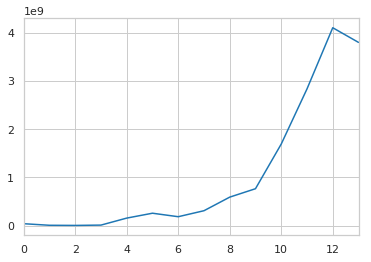

In [24]:
df.creation_duration.plot()

In [25]:
def createGraph_Language_LinksGraph(data):
    # create an empty graph from the nx (networkx) package imported above
    G=nx.Graph()

    rowCount=0
    seenAuthors=[]
    seenLanguages=[]
    seenPublishers=[]
    noRecords=len(data.keys())
    #print("Processing %i records."%noRecords)
    for ppn in data:
        #print(ppn)
        rowCount=rowCount+1
        if (rowCount%100000==0) and noRecords>100000:
            printLog("Processed %i records of %i"%(rowCount,noRecords))
        
        author=data[ppn]["author"]
        authorID=data[ppn]["authorID"]
        publisher=data[ppn]["publisher"]
        language=data[ppn]["language"]
        
        if not language in seenLanguages:
            G.add_node(language)
            G.node[language]['type']="language"
            seenLanguages.append(language)
        
        if author:
            if not author in seenAuthors:
                seenAuthors.append(author)
                G.add_node(author)
                # the name attribute will be helpful for D3.js visualizations
                G.node[author]['name'] = author
                G.node[author]['type'] = "author"
                if authorID:
                    G.node[author]['id'] = authorID
            G.add_edge(author,language)
            
        if publisher:
            if not publisher in seenPublishers:
                seenPublishers.append(publisher)
                G.add_node(publisher)
                G.node[publisher]['name'] = publisher
                G.node[publisher]['type'] = "publisher"
            G.add_edge(publisher,language)
            
    return G

In [26]:
dataFrameDict["language"].append("n/a")
dataFrameDict["graph_type"].append("languageLink")
printLog("Processing language link graph.")
printLog("Creating graph...")
startTime = datetime.now()
returnedGraph=createGraph_Language_LinksGraph(allRecords)
endTime = datetime.now()
dataFrameDict["nodes"].append(len(returnedGraph.nodes()))
dataFrameDict["edges"].append(len(returnedGraph.edges()))
dataFrameDict["records"].append(len(allRecords))
dataFrameDict["creation_duration"].append(endTime-startTime)
nx.write_gml(returnedGraph,"analysis/languageLink.gml")
jsonData = json_graph.node_link_data(returnedGraph, {'link': 'edges', 'source': 'from', 'target': 'to'})
with open("analysis/languageLink.json", "w") as write_file:
    json.dump(jsonData, write_file,default={'link': 'edges', 'source': 'from', 'target': 'to'})
nx.write_graphml(returnedGraph, "analysis/languageLink.graphml")
printLog("Done.")

df2 = pd.DataFrame(dataFrameDict)
df2.to_csv("social_analysis_statistics.csv",index=False)

[2019-03-18 11:35:06.746585]	Processing language link graph.
[2019-03-18 11:35:06.747536]	Creating graph...
[2019-03-18 11:35:38.077728]	Processed 100000 records of 115841
[2019-03-18 11:35:49.656892]	Done.


In [27]:
df2 = pd.DataFrame(dataFrameDict)
df2.head(30)

,language,graph_type,nodes,edges,creation_duration,records
0,fry,author_publisher_location,298,264,00:00:00.039962,360
1,fry,author_publisher_location_title,622,726,00:00:00.007417,360
2,ice,author_publisher_location,505,448,00:00:00.004605,1200
3,ice,author_publisher_location_title,1509,1393,00:00:00.011146,1200
4,por,author_publisher_location,5217,5392,00:00:00.156322,8937
5,por,author_publisher_location_title,12848,15219,00:00:00.257546,8937
6,nor,author_publisher_location,4949,6051,00:00:00.185055,12030
7,nor,author_publisher_location_title,15291,21753,00:00:00.309330,12030
8,dan,author_publisher_location,9128,11712,00:00:00.591001,20089
9,dan,author_publisher_location_title,26145,39279,00:00:00.765552,20089


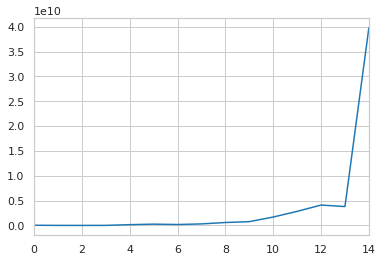

In [28]:
df2.creation_duration.plot()

In [29]:
df2

,language,graph_type,nodes,edges,creation_duration,records
0,fry,author_publisher_location,298,264,00:00:00.039962,360
1,fry,author_publisher_location_title,622,726,00:00:00.007417,360
2,ice,author_publisher_location,505,448,00:00:00.004605,1200
3,ice,author_publisher_location_title,1509,1393,00:00:00.011146,1200
4,por,author_publisher_location,5217,5392,00:00:00.156322,8937
5,por,author_publisher_location_title,12848,15219,00:00:00.257546,8937
6,nor,author_publisher_location,4949,6051,00:00:00.185055,12030
7,nor,author_publisher_location_title,15291,21753,00:00:00.309330,12030
8,dan,author_publisher_location,9128,11712,00:00:00.591001,20089
9,dan,author_publisher_location_title,26145,39279,00:00:00.765552,20089


https://networkx.github.io/documentation/stable/reference/algorithms/approximation.html